# How do movies export

Here is the notebook that contains our main logic and results for our comprehensive analysis of the CMU. Our anaylisis aims at recognizing parameteters that help movies export. We are mainly concern with factors that augment the ratio of the box office made outside of the production countries. 

In [62]:
# Mathematical and statistical libraries
import pandas as pd
import numpy as np
from scipy import stats

# Plotting libraries
import matplotlib.pyplot as plt
import plotly.offline as offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# CSV library
import ast

# Plot graphs
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path
import matplotlib.lines as mlines

In [63]:
df_analysis = pd.read_csv('analysis.csv', 
                       converters={'genres': ast.literal_eval,
                                   'languages': ast.literal_eval,
                                   'countries': ast.literal_eval})
df_analysis.head(5)

,tconst,Wiki_ID,Freebase_ID,country,movie,gross,release_date,countries,Ratio_Female_to_Total,num_female,num_male,languages,genres
0,tt0228333,975900,/m/03vyhn,Domestic,ghosts of mars,8709640.0,2001.0,[United States of America],0.352941,6.0,11.0,[English],"[Thriller, Adventure, Action, Science Fiction,..."
1,tt0228333,975900,/m/03vyhn,France,ghosts of mars,1937390.0,2001.0,[United States of America],0.352941,6.0,11.0,[English],"[Thriller, Adventure, Action, Science Fiction,..."
2,tt0228333,975900,/m/03vyhn,Spain,ghosts of mars,509536.0,2001.0,[United States of America],0.352941,6.0,11.0,[English],"[Thriller, Adventure, Action, Science Fiction,..."
3,tt0228333,975900,/m/03vyhn,Germany,ghosts of mars,496679.0,2001.0,[United States of America],0.352941,6.0,11.0,[English],"[Thriller, Adventure, Action, Science Fiction,..."
4,tt0228333,975900,/m/03vyhn,United Kingdom,ghosts of mars,148898.0,2001.0,[United States of America],0.352941,6.0,11.0,[English],"[Thriller, Adventure, Action, Science Fiction,..."


In [3]:
# Here we clean df_analysis using the dictionary we made to map countries and avoid duplicates or similar countries like 
# Switzerland (French version) or Switzerland (German version) are simply Switzerland

# Load the CSV mapping into a pandas DataFrame
country_mapping_df = pd.read_csv('dictionnaries/country_mapping.csv')

# Ensure the 'Country_mapped' column is a list (it should be already based on your CSV content)
country_mapping_df['Country_mapped'] = country_mapping_df['Country_mapped'].apply(eval)

# Create a dictionary from the DataFrame for mapping
country_mapping_dict = pd.Series(country_mapping_df['Country_mapped'].values, index=country_mapping_df['Country']).to_dict()

# Define a function to map countries
def map_country(country):
    # Get the mapped value(s) from the dictionary
    mapped_values = country_mapping_dict.get(country, [country])
    return mapped_values

# Apply the function to the 'country' column
# This will create a series of lists, which we then explode into separate rows
df_analysis['country'] = df_analysis['country'].apply(map_country)


In the cell below we add a column to our dataset that contains the ratio of the gross made in a home country. We defined all the coproduciton countries as the home country, i.e. it means that this column for a movie made in the US and in france contain the sum of the revenue made in the US and in France over its total revenue. 

In [4]:
df_home_country  = df_analysis.copy()

print(df_home_country.iloc[213])
def is_home_country(row):
    return any(c in row['countries'] for c in row['country'])

# Sum up the gross for each movie in the `gross` dataframe
gross_sum = df_home_country.groupby('Wiki_ID')['gross'].sum().reset_index()
gross_sum.columns = ['Wiki_ID', 'total_gross']
# Merge this sum with the `movies` dataframe
df_home_country = df_home_country.merge(gross_sum, on='Wiki_ID', how='left')


df_home_country.dropna(subset=['countries'], inplace=True)
is_home = df_home_country.apply(is_home_country, axis=1)
df_home_country = df_home_country[is_home]

print(df_home_country.head())

df_home_country["ratio_of_home_country"] = df_home_country["gross"] / df_home_country["total_gross"]
df_home_country.head()


tconst                                                        tt0408236
Wiki_ID                                                         5549065
Freebase_ID                                                   /m/0ds11z
country                              [United States of America, Canada]
movie                    sweeney todd: the demon barber of fleet street
gross                                                        52898073.0
release_date                                                     2007.0
countries                    [United States of America, United Kingdom]
Ratio_Female_to_Total                                          0.230769
num_female                                                          3.0
num_male                                                           10.0
languages                                                     [English]
genres                                  [Drama, Crime, Horror, Musical]
Name: 213, dtype: object
       tconst   Wiki_ID Freebase_ID    

,tconst,Wiki_ID,Freebase_ID,country,movie,gross,release_date,countries,Ratio_Female_to_Total,num_female,num_male,languages,genres,total_gross,ratio_of_home_country
0,tt0228333,975900,/m/03vyhn,"[United States of America, Canada]",ghosts of mars,8709640.0,2001.0,[United States of America],0.352941,6.0,11.0,[English],"[Thriller, Adventure, Action, Science Fiction,...",11996794.0,0.725997
8,tt0058331,77856,/m/0kcn7,"[United States of America, Canada]",mary poppins,102272727.0,1964.0,[United States of America],0.461538,6.0,7.0,[English],"[Drama, Comedy, Science Fiction, Family Film, ...",103078757.0,0.992180
17,tt0892904,21926710,/m/05p45cv,"[United States of America, Canada]",white on rice,69171.0,2009.0,[United States of America],0.555556,5.0,4.0,[],"[Comedy, Romance Film, Indie]",69171.0,1.000000
18,tt0255819,156558,/m/014k4y,"[United States of America, Canada]",baby boy,28734552.0,2001.0,[United States of America],0.521739,12.0,11.0,[English],"[Drama, Crime]",28907684.0,0.994011
25,tt0405393,12008535,/m/02vlsqt,"[United States of America, Canada]",rudo y cursi,1827660.0,2008.0,"[Mexico, United States of America]",0.375000,3.0,5.0,[Spanish],"[Drama, Comedy]",11169232.0,0.163633


In [5]:
# Define the aggregation
aggregations = {
    'gross': 'sum',
    'ratio_of_home_country': 'sum',
    'country': 'sum'
}
all_agg = {col: 'first' for col in df_home_country.columns if col not in aggregations and col != "Wiki_ID"}
all_agg.update(aggregations)

# Now the home countries are combined
df_home_country_combined = df_home_country.groupby('Wiki_ID').agg(all_agg).reset_index()
df_home_country_combined.head()


,Wiki_ID,tconst,Freebase_ID,movie,release_date,countries,Ratio_Female_to_Total,num_female,num_male,languages,genres,total_gross,gross,ratio_of_home_country,country
0,3217,tt0106308,/m/014hr,army of darkness,1992.0,[United States of America],0.230769,3.0,10.0,[English],"[Drama, Comedy, Adventure, Action, Indie, Scie...",11505925.0,11502976.0,0.999744,"[United States of America, Canada]"
1,3746,tt0083658,/m/017n9,blade runner,1982.0,"[United States of America, Hong Kong]",0.214286,3.0,11.0,"[Japanese, Cantonese, English, German, Hungari...","[Drama, Thriller, Crime, Indie, World cinema, ...",40877529.0,32914489.0,0.805198,"[United States of America, Canada]"
2,3837,tt0071230,/m/018f8,blazing saddles,1974.0,[United States of America],0.100000,2.0,18.0,"[Yiddish, English]","[Comedy, Adventure]",119617265.0,119616663.0,0.999995,"[United States of America, Canada]"
3,3947,tt0090756,/m/0191n,blue velvet,1986.0,[United States of America],0.333333,5.0,10.0,[English],"[Thriller, Crime, Mystery]",8618766.0,8551228.0,0.992164,"[United States of America, Canada]"
4,4227,tt0072684,/m/01c9d,barry lyndon,1975.0,"[United States of America, United Kingdom]",0.222222,2.0,7.0,"[French, English, German]","[Drama, Romance Film, History]",245878.0,216472.0,0.880404,[United Kingdom]


In [6]:
total_home_per_year = df_home_country_combined.groupby('release_date')['gross'].sum()
total_per_year = df_home_country_combined.groupby('release_date')['total_gross'].sum()

# Calculate the ratio of foreign box office to total box office
ratio_foreign_box_office = 1 - total_home_per_year / total_per_year

# Create an interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ratio_foreign_box_office.index, 
    y=ratio_foreign_box_office.values,
    mode='lines',
    name='Ratio of Foreign Box Office'
))

fig.update_layout(
    title='Ratio of Foreign Box Office as a Function of the Year',
    xaxis=dict(title='Release Year', range=[1970, 2015]),
    yaxis=dict(title='Ratio of Foreign Box Office', range=[0, 1]),
    hovermode='x'
)

# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/foreign_evolution.html', auto_open=False)

# Show the figure
fig.show()

Here we see that the movies tend to export more and more through the year with a clear augmentation starting around the 90'. 

In [7]:
gender_analysis = df_home_country_combined.copy()
# Define bin edges for 0.1 intervals
bin_edges = np.arange(0, gender_analysis['Ratio_Female_to_Total'].max() + 0.05, 0.05)

# Assign each x value to a bin
gender_analysis['x_bin'] = pd.cut(gender_analysis['Ratio_Female_to_Total'], bins=bin_edges, labels=bin_edges[:-1], right=False)

# Group by the bin and calculate the mean y value for each bin
binned_avg = gender_analysis.groupby('x_bin')['total_gross'].mean()

# Create an interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=binned_avg.index.astype(str),
    y=binned_avg.values,
    mode='lines',
    name='Average Total Gross'
))

# Correctly set tick values and labels
tick_values = np.arange(0, 1, 0.1)  
tick_labels = [f'{x:.1f}' for x in tick_values] 

fig.update_layout(
    title='Average Total Gross by Ratio of Females',
    xaxis=dict(
        title='Ratio of Females',
        tickmode='array',
        tickvals=tick_values, 
        ticktext=tick_labels,  
        tickangle=0
    ),
    yaxis=dict(
        title='Average Total Gross'
    ),
    hovermode='x'
)

#offline.plot(fig, filename='docs/plots/gross_female.html', auto_open=False)

fig.show()

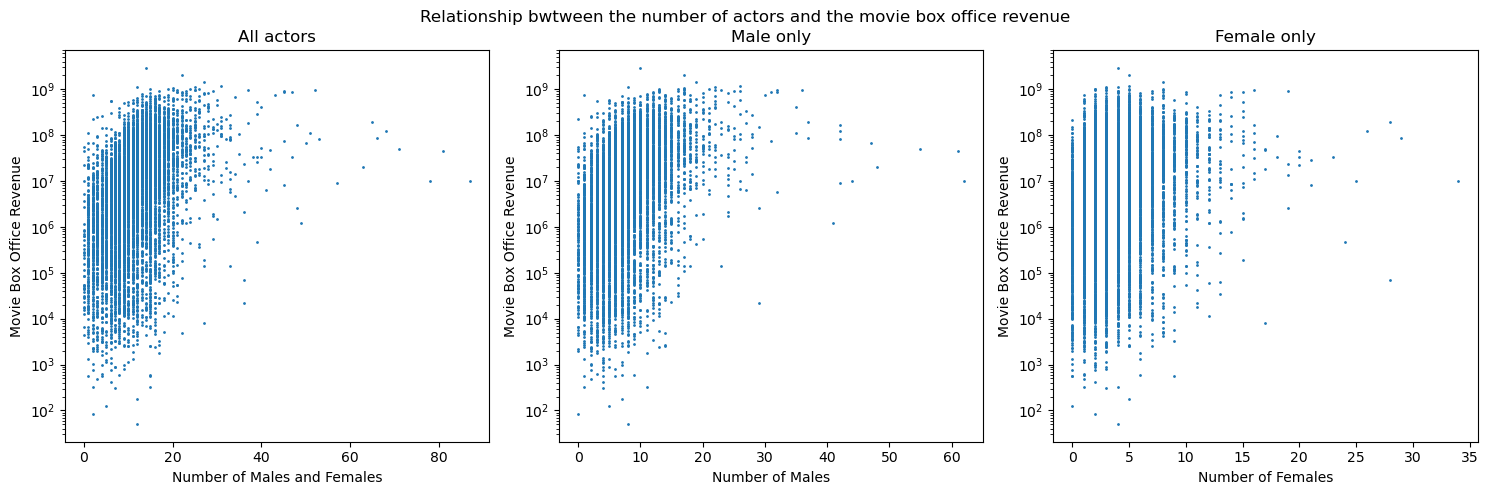

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot 1: Number of Females vs. Movie Box Office Revenue
axes[2].scatter(gender_analysis['num_female'], gender_analysis['total_gross'], s=1)
axes[2].set_yscale('log')
axes[2].set_xlabel('Number of Females')
axes[2].set_ylabel('Movie Box Office Revenue')
axes[2].set_title('Female only')

# Plot 2: Number of Males vs. Movie Box Office Revenue
axes[1].scatter(gender_analysis['num_male'], gender_analysis['total_gross'], s=1)
axes[1].set_yscale('log')
axes[1].set_xlabel('Number of Males')
axes[1].set_ylabel('Movie Box Office Revenue')
axes[1].set_title('Male only')

# Plot 3: Number of Males and Females vs. Movie Box Office Revenue
axes[0].scatter(gender_analysis['num_male'] + gender_analysis['num_female'], gender_analysis['total_gross'], s=1)
axes[0].set_yscale('log')
axes[0].set_xlabel('Number of Males and Females')
axes[0].set_ylabel('Movie Box Office Revenue')
axes[0].set_title('All actors')

# Adjust spacing between subplots
plt.tight_layout()
fig.suptitle("Relationship bwtween the number of actors and the movie box office revenue")

plt.subplots_adjust(top=0.9)

# Show the combined plot
plt.show()

In [9]:
# compute spearman correlation between 'num_female' and 'movie_box_office_revenue'
print("Relation between # of females and gross: ", 
      stats.spearmanr(gender_analysis['num_female'], gender_analysis['total_gross'], nan_policy='omit'))
# compute spearman correlation between 'num_male' and 'movie_box_office_revenue'
print("Relation between # of males and gross: ", 
      stats.spearmanr( gender_analysis['num_male'], gender_analysis['total_gross'], nan_policy='omit'))
# compute spearman correlation between 'num_actors' and 'movie_box_office_revenue'
print("Relation between # of actors and gross: ", 
      stats.spearmanr(gender_analysis['num_male'] + gender_analysis['num_female'], gender_analysis['total_gross'], nan_policy='omit'))

Relation between # of females and gross:  SignificanceResult(statistic=0.2788617467707724, pvalue=7.587279578260463e-151)
Relation between # of males and gross:  SignificanceResult(statistic=0.47456179900193973, pvalue=0.0)
Relation between # of actors and gross:  SignificanceResult(statistic=0.4894216187490504, pvalue=0.0)


## Ethnicity


In [10]:
character_ethnicity = pd.read_csv("dictionnaries/character_ethnicity.csv")

In [11]:
# Number of ethnicities per Wiki_ID
n_ethn = character_ethnicity.groupby("Wiki_ID")["actor_ethnicity"].count().reset_index()


In [12]:
ethnicity_analysis = df_home_country_combined.copy()


In [13]:
# find the number of each ethinicities in each movie
ethnicity_counts = character_ethnicity.groupby(['Wiki_ID', 'actor_ethnicity']).size().reset_index(name='counts')

# find the number of actors in each movie of which we have an ethnicity
n_ethn_actors = ethnicity_counts.dropna(subset="counts").groupby("Wiki_ID")["counts"].sum().reset_index()
n_ethn_actors.columns = ["Wiki_ID", "n_ethn_actor"]

ethnicity_counts_nethn = ethnicity_counts.merge(n_ethn_actors, on = "Wiki_ID", how = "left",)
ethnicity_counts_nethn["proportion"]= ethnicity_counts_nethn.counts/ethnicity_counts_nethn.n_ethn_actor
ethnicity_counts_nethn.head(20)

,Wiki_ID,actor_ethnicity,counts,n_ethn_actor,proportion
0,330,/m/03ttfc,1,1,1.000000
1,3217,/m/06v41q,1,2,0.500000
2,3217,/m/07hwkr,1,2,0.500000
3,3333,/m/07bch9,1,1,1.000000
4,3746,/m/01336l,1,4,0.250000
5,3746,/m/01g7zj,1,4,0.250000
6,3746,/m/01qhm_,1,4,0.250000
7,3746,/m/05l3g_,1,4,0.250000
8,3837,/m/041rx,2,9,0.222222
9,3837,/m/048z7l,1,9,0.111111


In [14]:
#Calculate the entropy of each ethnicity
ethn_entropy = ethnicity_counts_nethn.groupby("Wiki_ID").apply(lambda x: -np.sum(x["proportion"]*np.log(x["proportion"])/np.log(2)))
ethn_entropy = ethn_entropy.reset_index(name="ethn_entropy")

ethn_entropy = ethn_entropy.merge(ethnicity_counts_nethn[["Wiki_ID","n_ethn_actor"]], on = "Wiki_ID", how = "left")[["Wiki_ID","ethn_entropy"]].drop_duplicates()
ethn_entropy.head(10)


,Wiki_ID,ethn_entropy
0,330,-0.000000
1,3217,1.000000
3,3333,-0.000000
4,3746,2.000000
8,3837,2.419382
14,3947,1.584963
17,4227,1.584963
20,4231,2.155639
25,4560,2.419382
31,4726,2.584963


In [15]:
#Combine to main dataframe
ethn_score_analysis = df_home_country_combined.copy()
ethn_score_analysis = ethn_score_analysis.merge(ethn_entropy[["Wiki_ID","ethn_entropy"]], on = "Wiki_ID", how = "left")


In [16]:
# Calculate the average values in bins
average_ratio_per_ethn = ethn_score_analysis.groupby(pd.cut(ethn_score_analysis['ethn_entropy'], bins=np.arange(0-0.05,ethn_score_analysis['ethn_entropy'].max()+0.1, 0.1)))["ratio_of_home_country"].mean()
average_ratio_per_ethn.interpolate(inplace=True)

# Create a scatter plot using Plotly
fig = go.Figure(data=go.Scatter(
    x=average_ratio_per_ethn.index.categories.mid, 
    y=1-average_ratio_per_ethn, 
    mode='lines',
    hoverinfo='y'
))

# Set the axis labels and title
fig.update_layout(
    xaxis_title='Ethnicity Entropy',
    yaxis_title='Average Ratio of Gross Exported',
    yaxis_range=[0, 1],
    title='Average Ratio of Gross Exported as a Function of Ethnicity Entropy',
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
)
)

#add histogram in background
total_n = ethn_score_analysis.groupby(pd.cut(ethn_score_analysis['ethn_entropy'], bins=np.arange(0-0.05,ethn_score_analysis['ethn_entropy'].max()+0.2, 0.2)))["ratio_of_home_country"].count()
fig.add_trace(go.Histogram(x=ethn_score_analysis["ethn_entropy"], nbinsx=20, histnorm='probability density', marker=dict(color='rgba(0,0,0,0.1)'),hovertemplate='Total Count: %{text}', text=total_n,texttemplate=' '))

#rename the labels of the traces
fig.data[0].name = "Ratio of Gross Exported"
fig.data[1].name = "Count probability density"

#put the legend below
fig.update_layout()

#offline.plot(fig, filename='docs/plots/ethn_entropy.html', auto_open=False)

fig.show()


# Genre

In [17]:
df_genre_analysis = df_home_country_combined.copy()

# Create a one hot encoding for genres
df_genres_dummies = df_genre_analysis[["Wiki_ID", "genres"]].copy()
df_genres_dummies = df_genres_dummies.explode("genres")
df_genres_dummies = pd.get_dummies(df_genres_dummies, columns=["genres"])

# sum the one hot encoding (genres col) by Wiki_ID
df_genres_dummies = df_genres_dummies.groupby("Wiki_ID").sum().reset_index()

# keep the 50 most common genres
top_genres = df_genres_dummies.sum().sort_values(ascending=False).index[:50].tolist()
df_genres_dummies = df_genres_dummies[top_genres]

# Merge with original dataframe
df_genre_analysis = df_genre_analysis.merge(df_genres_dummies, on = "Wiki_ID", how = "left")

top_10_genres = top_genres[:10]

df_genre_analysis.head()

,Wiki_ID,tconst,Freebase_ID,movie,release_date,countries,Ratio_Female_to_Total,num_female,num_male,languages,...,genres_Crime,genres_Science Fiction,genres_World cinema,genres_Family Film,genres_Horror,genres_Documentary,genres_Mystery,genres_Musical,genres_History,genres_Teen
0,3217,tt0106308,/m/014hr,army of darkness,1992.0,[United States of America],0.230769,3.0,10.0,[English],...,0,1,0,0,1,0,0,0,0,0
1,3746,tt0083658,/m/017n9,blade runner,1982.0,"[United States of America, Hong Kong]",0.214286,3.0,11.0,"[Japanese, Cantonese, English, German, Hungari...",...,1,1,1,0,0,0,0,0,0,0
2,3837,tt0071230,/m/018f8,blazing saddles,1974.0,[United States of America],0.100000,2.0,18.0,"[Yiddish, English]",...,0,0,0,0,0,0,0,0,0,0
3,3947,tt0090756,/m/0191n,blue velvet,1986.0,[United States of America],0.333333,5.0,10.0,[English],...,1,0,0,0,0,0,1,0,0,0
4,4227,tt0072684,/m/01c9d,barry lyndon,1975.0,"[United States of America, United Kingdom]",0.222222,2.0,7.0,"[French, English, German]",...,0,0,0,0,0,0,0,0,1,0


In [18]:
genres_cols = list(df_genres_dummies.columns)[1:]

# Compute the mean ratio of home country for each genre
mean_ratio = {}
for genre in genres_cols:
    mean_ratio[genre] = df_genre_analysis[df_genre_analysis[genre] == 1]["ratio_of_home_country"].mean()

df_mean_ratio = pd.DataFrame(list(mean_ratio.items()), columns=['genre', 'mean_ratio'])

# Sort the dataframe by mean ratio in ascending orde
df_mean_ratio['mean_ratio'] = 1 - df_mean_ratio['mean_ratio']
df_mean_ratio.sort_values(by=['mean_ratio'], inplace=True)
# delete the first 7 characters of the genre column
df_mean_ratio['genre'] = df_mean_ratio['genre'].str[7:]

# Create an interactive bar plot with specified dimensions and color
fig = go.Figure(data=[go.Bar(
    x=df_mean_ratio['genre'],
    y=df_mean_ratio['mean_ratio'],
    name='Mean Ratio of Foreign Box Office',
    hoverinfo='y',
)])

# Update the layout
fig.update_layout(
    title='Most International Genres',
    xaxis=dict(
        title='Genre',
        tickangle=90
    ),
    yaxis=dict(
        title='Mean Ratio of Foreign Box Office',
        range=[0, 1]
    ),
    autosize=False,
)

# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/most_international_genres.html', auto_open=False)

# Show the figure
fig.show()


# todo


In [19]:
# Get a list of unique release dates
release_dates = df_genre_analysis['release_date'].unique()
genres_cols = list(df_genres_dummies.columns)[1:]

# For each release date, compute the mean ratio of home country for each genre
mean_ratio_per_year = {}
for date in release_dates:
    mean_ratio_per_year[date] = {}
    for genre in genres_cols:
        mean_ratio_per_year[date][genre] = df_genre_analysis[(df_genre_analysis[genre] == 1) & (df_genre_analysis['release_date'] == date)]["ratio_of_home_country"].mean()

# Create a dataframe from the dictionary
df_mean_ratio_per_year = pd.DataFrame(mean_ratio_per_year)

# Do 1 - mean_ratio to get the ratio of foreign box office
df_mean_ratio_per_year = 1 - df_mean_ratio_per_year

# Replace Nan with 0
df_mean_ratio_per_year.fillna(0, inplace=True)

# Plot the mean ratio of foreign box office for each genre over time
# Plot a lign for each genre
# Transpose the DataFrame to get years as rows
df_mean_ratio_per_year = df_mean_ratio_per_year.T

# Order the years
df_mean_ratio_per_year.sort_index(inplace=True)

# Fill missing last year values
df_mean_ratio_per_year.iloc[-3][df_mean_ratio_per_year.iloc[-3] == 0] = df_mean_ratio_per_year.iloc[-4][df_mean_ratio_per_year.iloc[-3] == 0]
df_mean_ratio_per_year.iloc[-2][df_mean_ratio_per_year.iloc[-2] == 0] = df_mean_ratio_per_year.iloc[-3][df_mean_ratio_per_year.iloc[-2] == 0]
df_mean_ratio_per_year.iloc[-1][df_mean_ratio_per_year.iloc[-1] == 0] = df_mean_ratio_per_year.iloc[-2][df_mean_ratio_per_year.iloc[-1] == 0] 


# Initialize the figure
fig = go.Figure()

# Add traces
for genre in genres_cols:
    fig.add_trace(go.Scatter(
        x=df_mean_ratio_per_year.index,
        y=df_mean_ratio_per_year[genre],
        mode='lines',
        name=genre[7:], 
       
    ))

# Set the layout
fig.update_layout(
    title='Genre Popularity Over Years',
    xaxis=dict(title='Year', range=[2000, 2013], dtick=1),
    yaxis=dict(title='Mean Ratio of Foreign Box Office'),
    legend=dict(title='Genre'), 
)

# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/genre_evolution.html', auto_open=False)

# Show the figure
fig.show()


# Pair Matching 
todo 

# Countries analysis

In [20]:
countries_analysis = df_home_country_combined.copy()
countries_analysis

,Wiki_ID,tconst,Freebase_ID,movie,release_date,countries,Ratio_Female_to_Total,num_female,num_male,languages,genres,total_gross,gross,ratio_of_home_country,country
0,3217,tt0106308,/m/014hr,army of darkness,1992.0,[United States of America],0.230769,3.0,10.0,[English],"[Drama, Comedy, Adventure, Action, Indie, Scie...",11505925.0,11502976.0,0.999744,"[United States of America, Canada]"
1,3746,tt0083658,/m/017n9,blade runner,1982.0,"[United States of America, Hong Kong]",0.214286,3.0,11.0,"[Japanese, Cantonese, English, German, Hungari...","[Drama, Thriller, Crime, Indie, World cinema, ...",40877529.0,32914489.0,0.805198,"[United States of America, Canada]"
2,3837,tt0071230,/m/018f8,blazing saddles,1974.0,[United States of America],0.100000,2.0,18.0,"[Yiddish, English]","[Comedy, Adventure]",119617265.0,119616663.0,0.999995,"[United States of America, Canada]"
3,3947,tt0090756,/m/0191n,blue velvet,1986.0,[United States of America],0.333333,5.0,10.0,[English],"[Thriller, Crime, Mystery]",8618766.0,8551228.0,0.992164,"[United States of America, Canada]"
4,4227,tt0072684,/m/01c9d,barry lyndon,1975.0,"[United States of America, United Kingdom]",0.222222,2.0,7.0,"[French, English, German]","[Drama, Romance Film, History]",245878.0,216472.0,0.880404,[United Kingdom]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8814,36683360,tt2247692,/m/0kvfm_7,2016: obama's america,2012.0,[United States of America],NaN,NaN,NaN,[English],[Documentary],33449086.0,33449086.0,1.000000,"[United States of America, Canada]"
8815,36899099,tt1833844,/m/0lq63z9,berberian sound studio,2012.0,[United Kingdom],0.000000,0.0,2.0,[],[Horror],312757.0,256722.0,0.820835,[United Kingdom]
8816,36929245,tt2209418,/m/0m0l_0b,before midnight,2013.0,[United States of America],NaN,NaN,NaN,[English],"[Drama, Romance Film]",20994648.0,8114627.0,0.386509,"[United States of America, Canada]"
8817,37210334,tt1322269,/m/0n52lw7,august: osage county,2013.0,[United States of America],NaN,NaN,NaN,[],"[Drama, Comedy]",69822917.0,37738810.0,0.540493,"[United States of America, Canada]"


In [21]:
# Reformat the genre column
top_10_genres= top_genres[1:11]
top_10_genres = [genre[7:] for genre in top_10_genres]

In [22]:
# Creates the columns for the number of co-production countries
countries_analysis['num_coprod'] = countries_analysis['countries'].apply(lambda x: len(x))

In [23]:
# Filter data to include only movies with more than one co-production country
filtered_data = countries_analysis[countries_analysis['num_coprod'] > 1]

# Count the number of movies per year
movies_per_year = filtered_data.groupby('release_date').size()

# Count the total number of movies per year
total_movies_per_year = countries_analysis.groupby('release_date').size()

# Calculate the ratio
ratio_movies = movies_per_year / total_movies_per_year

# Create an interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ratio_movies.index, 
    y=ratio_movies.values,
    mode='lines',
    name='Ratio of Movies', 
    hoverinfo='y'
))

fig.update_layout(
    title='Ratio of Movies with More Than One Co-production Country Over Time',
    xaxis=dict(title='Release Year', range=[1980, 2013], dtick=5),
    yaxis_title='Ratio of Movies',
    hovermode='closest'
)

#offline.plot(fig, filename='docs/plots/movies_coprod_ratio.html', auto_open=False)

fig.show()

As we see, as time advances movie production companies from different countries seem to work more and more together, but the ratio of films made in co-production barely goes up. From this graph we saw that there was a little increase in the ratio of movies that were made by mutlitple countries in the last 20 years. This small increase leads us to think that having a co-production would slightly boost the revenue of a movie. The question now is how many coutries should you have to maximize your revenue? And how many co-producing countries should you have if you want to maximize the ratio of the revenue made outside the production countries?

In [24]:
# compute spearman correlation between 'num_coprod' and 'movie_box_office_revenue'
print('Relation between # of coproductions and gross: ', 
      stats.spearmanr(countries_analysis['num_coprod'], countries_analysis['total_gross'], nan_policy='omit'))
# compute spearman correlation between 'num_coprod' and 'home_country_ratio'
print('Relation between # of coproductions and intenationl revenue ratio: ', 
      stats.spearmanr(countries_analysis['num_coprod'], 1-countries_analysis['ratio_of_home_country'], nan_policy='omit'))

Relation between # of coproductions and gross:  SignificanceResult(statistic=0.013663866852369918, pvalue=0.1994761954030343)
Relation between # of coproductions and intenationl revenue ratio:  SignificanceResult(statistic=0.2455170117100698, pvalue=3.1990616810089583e-121)


In [25]:
# We keep only movies with less than 4 coproductions because there are only 4 movies with more than 4 coproductions
coprod = countries_analysis[countries_analysis['num_coprod'] <= 4].copy()

In [26]:
# Group data and calculate mean revenue
mean_revenue = coprod.groupby('num_coprod')['total_gross'].mean()

# Create an interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_revenue.index,
    y=mean_revenue.values,
    mode='lines',
    name='Mean Revenue'
))

fig.update_layout(
    title='Mean Revenue as a Function of the Number of Coproductions',
    xaxis=dict(
        title='Number of Coproductions',
        range = [0.75, 4.25],
        tickmode='array',  # Setting tick mode to array
        tickvals=np.arange(mean_revenue.index.min() , mean_revenue.index.max() + 1, 1)  # Integer ticks
    ),
    yaxis=dict(
        title='Mean Revenue',
        type='log'  # Logarithmic scale
    ),
    hovermode='x'
)


# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/mean_revenue_coprod_number.html', auto_open=False)

fig.show()

So on average movies made in two countries are the one yielding the most revenues. The use of T-test allowed us to see that the difference in mean was statistically significant, which allows us to conclude that the collaboration of two countries should lead on average to a higher grossing film than any other number of co-production coutries. Even if the test allows us to say that the difference is statistically different the T-statistic is rather small (~2), this tells us that even if the difference exists it doesn’t have a huge impact. The section above told us that the genre of a movie has an influence so let us see if all genres perform the same.

In [27]:
# Filter the dataframe for movies made only in One country
no_coprod = countries_analysis[countries_analysis['countries'].apply(lambda x: len(x) == 1)]

# Filter the dataframe for movies made in multiple countries
with_coprod = countries_analysis[countries_analysis['countries'].apply(lambda x: len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(no_coprod['total_gross'], with_coprod['total_gross'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies made in one country and movies made in multiple countries:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

# Filter the dataframe for movies made only in two countries
two_coprod = countries_analysis[countries_analysis['countries'].apply(lambda x: len(x) == 2)]

# Filter the dataframe to have the complement of the previous filter
other_movies = countries_analysis[countries_analysis['countries'].apply(lambda x: len(x) == 1 or len(x) > 2)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(two_coprod['total_gross'], other_movies['total_gross'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies made in two countries and movies made in one or more than two countries:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

# Filter the dataframe for movies made only in three countries
three_coprod = countries_analysis[countries_analysis['countries'].apply(lambda x: len(x) == 3)]

# Filter the dataframe to have the complement of the previous filter
other_movies = countries_analysis[countries_analysis['countries'].apply(lambda x: len(x) == 1 or len(x) == 2 or len(x) > 3)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(three_coprod['total_gross'], other_movies['total_gross'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies made in three countries and movies made in one, two or more than three countries:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

Result of the t-test opposing movies made in one country and movies made in multiple countries:
	T-statistic: -2.905947596509872
	P-value: 0.0036862736630869936
Result of the t-test opposing movies made in two countries and movies made in one or more than two countries:
	T-statistic: 3.3354799611562105
	P-value: 0.0008689828271102691
Result of the t-test opposing movies made in three countries and movies made in one, two or more than three countries:
	T-statistic: -0.02176609729304701
	P-value: 0.9826419843682863


In [28]:
# Group data and calculate median revenue
median_revenue = coprod.groupby('num_coprod')['total_gross'].median()

# Create an interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=median_revenue.index,
    y=median_revenue.values,
    mode='lines',
    name='Median Revenue'
))

fig.update_layout(
    title='Median Revenue as a Function of the Number of Coproductions',
     xaxis=dict(
        title='Number of Coproductions',
        range = [0.75, 4.25],
        tickmode='array',  # Setting tick mode to array
        tickvals=np.arange(mean_revenue.index.min(), mean_revenue.index.max() + 1, 1)  # Integer ticks
    ),
    yaxis=dict(
        title='Median Revenue',
        # Fix the size of the graph on the y axis from 0 to 140M going up by 20M
        tickmode='array',
    ),
    hovermode='x'
)




# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/median_revenue_coprod_genre.html', auto_open=False)

fig.show()

These t- test clearly show that the best # of co-produciton movies is 2, the difference isn't huge with a t-stat of around 3 but it still is statistically significant

In [29]:
fig = go.Figure()

# Plot lines for each of the top 10 genres
for genre in top_10_genres:
    genre_movies = coprod[coprod['genres'].apply(lambda x: genre in x if isinstance(x, list) else False)]
    fig.add_trace(go.Scatter(x=genre_movies.groupby('num_coprod')['total_gross'].mean().index,
                             y=genre_movies.groupby('num_coprod')['total_gross'].mean(),
                             mode='lines', 
                             name=genre))

# Plot line for movies not in any of the top 10 genres

fig.update_layout(
    title='Mean Revenue as a Function of the Number of Coproductions',
    xaxis=dict(
        title='Number of Coproductions',
        range = [0.75, 4.25],
        tickmode='array',  # Setting tick mode to array
        tickvals=np.arange(mean_revenue.index.min(), mean_revenue.index.max() + 1, 1)  # Integer ticks
    ),
    yaxis=dict(
        title='Mean Revenue',
        # Fix the size of the graph on the y axis from 0 to 140M going up by 20M
        range=[0, 140000000],
        tickmode='array',
        tickvals=np.arange(0, 160000000, 20000000)
    ),
)

# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/tot_coprod_genre.html', auto_open=False)

fig.show()

For most genre we will have the same conclusion as for all movies, i.e. two coproduction countries is best. The notable exception are World Cinema, Romance Film and Comedy. We don’t have an explanation for what that is but the fact that Romance Film and Comedy behave in the same way isn’t surprising as 60% of movies that are romantic are also comedies and 40% of comedies are romantic films as well. For the World Cinema genre, we give an explanation about why it might behave like that after we analyse the number or production region for a movie.

In [30]:
comedies = coprod[coprod['genres'].apply(lambda x: 'Comedy' in x if isinstance(x, list) else False)]
comedies_not_romance = comedies[comedies['genres'].apply(lambda x: 'Romance Film' not in x if isinstance(x, list) else False)]
#ratio of comedies withou romance
print('Ratio of comedies that are not romatic films: ', comedies_not_romance.shape[0]/comedies.shape[0])

romance = coprod[coprod['genres'].apply(lambda x: 'Romance Film' in x if isinstance(x, list) else False)]
romance_not_comedies = romance[romance['genres'].apply(lambda x: 'Comedy' not in x if isinstance(x, list) else False)]
#ratio of romance without comedies
print('Ratio of romatic films that are not comedies', romance_not_comedies.shape[0]/romance.shape[0])


Ratio of comedies that are not romatic films:  0.6618370694368507
Ratio of romatic films that are not comedies 0.4328289775332416


Here we can see that the two genre often appears together so even if we don't have an explanation why three co-production countries perfrom better for this two genre. But it is normal that they have similar behaviour. 

In [31]:
fig = go.Figure()

fig.add_trace(go.Box(
    y=1 - coprod[coprod['num_coprod'] == 1]["ratio_of_home_country"],
    name='1',
    text=coprod[coprod['num_coprod'] == 1]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>',  # Customize hover template
))

fig.add_trace(go.Box(
    y=1 - coprod[coprod['num_coprod'] == 2]["ratio_of_home_country"],
    name='2',
    text=coprod[coprod['num_coprod'] == 2]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.add_trace(go.Box(
    y=1 - coprod[coprod['num_coprod'] == 3]["ratio_of_home_country"],
    name='3',
    text=coprod[coprod['num_coprod'] == 3]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.add_trace(go.Box(
    y=1 - coprod[coprod['num_coprod'] == 4]["ratio_of_home_country"],
    name='4',
    text=coprod[coprod['num_coprod'] == 4]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.update_layout(
    title='Ratio of International Revenue as a Function of the Number of Coproductions',
    xaxis_title='Number of Coproductions',
    yaxis_title='Ratio of International Revenue',
    showlegend=False
)

# offline.plot(fig, filename='docs/plots/ratio_int_box_coprod.html', auto_open=False)

fig.show()

In [32]:
import plotly.graph_objects as go

# Group data and calculate mean ratio of international revenue
mean_ratio = 1 - coprod.groupby('num_coprod')['ratio_of_home_country'].mean()

# Create an interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_ratio.index,
    y=mean_ratio.values,
    mode='lines',
    name='Mean Ratio of International Revenue'
))

fig.update_layout(
    title='Mean Ratio of International Revenue as a Function of the Number of Coproductions',
    xaxis=dict(
        title='Number of Coproductions',
        range = [0.75, 4.25],
        tickmode='array',  # Setting tick mode to array
        tickvals=np.arange(mean_ratio.index.min(), mean_ratio.index.max() + 1, 1)  # Integer ticks
    ),
    yaxis=dict(
        title='Mean Ratio of International Revenue',
        range=[0, 1],  # Set the range of y-axis from 0 to 1
        tickmode='array',
        tickvals=np.arange(0, 1.1, 0.1)  # Tick values from 0 to 1 with step of 0.1
    ),
    hovermode='x'
)

# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/mean_ratio_coprod.html', auto_open=False)
fig.show()

In [33]:
# Filter the dataframe for movies made only in the United States of America
no_coprod = countries_analysis[countries_analysis['countries'].apply(lambda x: len(x) == 1)]

# Filter the dataframe for movies made in the United States of America and somewhere else
with_coprod = countries_analysis[countries_analysis['countries'].apply(lambda x: len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(1- no_coprod['ratio_of_home_country'], 1 - with_coprod['ratio_of_home_country'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies made in one country and movies made in multiple countries:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

# Filter the dataframe for movies made only in the United States of America
usa_movies = countries_analysis[countries_analysis['countries'].apply(lambda x: 'United States of America' in x and len(x) == 1)]

# Filter the dataframe for movies made in the United States of America and somewhere else
other_movies = countries_analysis[countries_analysis['countries'].apply(lambda x: 'United States of America' in x and len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(1- usa_movies['ratio_of_home_country'], 1 - other_movies['ratio_of_home_country'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies made in the United States of America and movies made in the United States of America and somewhere else:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

# Filter the dataframe for movies made only in the United States of America
fr_movies = countries_analysis[countries_analysis['countries'].apply(lambda x: 'France' in x and len(x) == 1)]

# Filter the dataframe for movies made in the United States of America and somewhere else
other_movies = countries_analysis[countries_analysis['countries'].apply(lambda x: 'France' in x and len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(1- fr_movies['ratio_of_home_country'], 1 - other_movies['ratio_of_home_country'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies made in France and movies made in France and somewhere else:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

# Filter the dataframe for movies made only in the United States of America
ind_movies = countries_analysis[countries_analysis['countries'].apply(lambda x: 'India' in x and len(x) == 1)]

# Filter the dataframe for movies made in the United States of America and somewhere else
other_movies = countries_analysis[countries_analysis['countries'].apply(lambda x: 'India' in x and len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(1- ind_movies['ratio_of_home_country'], 1 - other_movies['ratio_of_home_country'], equal_var=False)

# Print the t-statistic and p-value
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

Result of the t-test opposing movies made in one country and movies made in multiple countries:
	T-statistic: -19.21857642304363
	P-value: 3.358494799452428e-78
Result of the t-test opposing movies made in the United States of America and movies made in the United States of America and somewhere else:
	T-statistic: -13.930785043356908
	P-value: 1.4994232248992925e-42
Result of the t-test opposing movies made in France and movies made in France and somewhere else:
	T-statistic: -3.3010869047178106
	P-value: 0.0011400682478653538
	T-statistic: -3.9854441228823614
	P-value: 0.0002777167143559273


Here we can see that the more coproduction countries we have the more the ratio of the revenue is made in foreign coutries, this result might be a little counter intuitive. If we had defined a main production country and we would have looked at the ratio of the revenue made outside of this country it would have seemed obvious that it would be higher, because part of the revenue would have bean made in secondary production country. Here we look at the ratio of the box office made outside of all the production countrie and we still have a positive correlation. As before the use of T-test allows us to be sure that the difference is statistically. Moreover, this time the T-statistic is much higher (for 1 country vs. multiple T-stat ~ -19). With the same reasoning as before we can now look at different genre behave regarding the number of coprod countries. We did various T-test to see which country augmented their export by coproducing movies. With a T-statistique of around -13 the USA is the one country from the few we analyzed that gains the most when coproducing with other countries. France and India also gain a bit but the difference is much lower both have a T-statistic of ~3.

In [34]:
# Plot with mean revenue for each number of coproductions
fig = go.Figure()

# Plot lines for each of the top 10 genres
for genre in top_10_genres:
    genre_movies = coprod[coprod['genres'].apply(lambda x: genre in x if isinstance(x, list) else False)]
    fig.add_trace(go.Scatter(x=genre_movies.groupby('num_coprod')['ratio_of_home_country'].mean().index,
                             y=1 - genre_movies.groupby('num_coprod')['ratio_of_home_country'].mean(),
                             mode='lines',  # Add 'markers' to the mode
                             name=genre))

# Plot line for movies not in any of the top 10 genres


fig.update_layout(
    title='Ratio of international revenue as a Function of the Number of Coproductions',
    xaxis_title='Number of Coproductions',
    xaxis=dict(range = [0.75, 4.25], tickmode='linear', dtick=1),  # Set the x-axis range and tick interval
    yaxis_title='Mean revenue',
    yaxis=dict(range=[0, 1], tickmode='linear', dtick=0.1)  # Set the y-axis range and tick interval
)


# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/ratio_int_coprod_genre.html', auto_open=False)


fig.show()

In this case almost all genre seem to follow the expected trend with small variation. The only notable exception to the rule is the Thriller genre that has a ratio of international revenue that goes down when we reach 4 coproduction countries.

# Region

In [35]:
# Load the country to region dictionary
country_to_region = pd.read_csv('dictionnaries/country_to_region.csv')

# Create a function to get the region(s) for a list of countries
def get_region(countries):
    regions = country_to_region[country_to_region['Country'].isin(countries)]['Region'].tolist()
    return list(set(regions))  # Remove duplicates if multiple countries have the same region

# Add the 'prod_region' column to df_home_country_combined
countries_analysis['prod_region'] = countries_analysis['countries'].apply(lambda x: get_region(x))

In [36]:
one_region = countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 1)]

mult_regions = countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(1- one_region['ratio_of_home_country'], 1 - mult_regions['ratio_of_home_country'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies made in one region and movies made in multiple regions:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)


Result of the t-test opposing movies made in one region and movies made in multiple regions:
	T-statistic: -12.387690812402093
	P-value: 3.335591307041787e-34


In [37]:

fig = go.Figure()
fig.add_trace(go.Box(
    y=1 - countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 1)]["ratio_of_home_country"],
    name='one region',
    text=countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 1)]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.add_trace(go.Box(
    y=1 - countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 2)]["ratio_of_home_country"], 
    name='two regions', 
    text=countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 2)]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.add_trace(go.Box(
    y=1 - countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 3)]["ratio_of_home_country"], 
    name='three regions',
    text=countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 3)]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))


fig.update_layout(
    title='Ratio of international revenue as a Function of the Number of regions',
    xaxis_title='Number of Coproductions',
    yaxis_title='ration of international revenue',
    showlegend=False 
)

# offline.plot(fig, filename='docs/plots/ratio_int_box_region.html', auto_open=False)

fig.show()

In [38]:

fig = go.Figure()
fig.add_trace(go.Box(
    y=countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 1)]["total_gross"],
    name='one region',
    text=countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 1)]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.add_trace(go.Box(
    y=countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 2)]["total_gross"], 
    name='two regions', 
    text=countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 2)]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.add_trace(go.Box(
    y=countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 3)]["total_gross"], 
    name='three regions',
    text=countries_analysis[countries_analysis['prod_region'].apply(lambda x: len(x) == 3)]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))


fig.update_layout(
    title='Total revenue as a Function of the Number of regions',
    xaxis_title='Number of Coproductions',
    yaxis_title='Total revenue',
    yaxis_type= 'log',
    showlegend=False 
)


# offline.plot(fig, filename='docs/plots/int_box_region.html', auto_open=False)

fig.show()

In [39]:
# film with more than one coproduction country
co_prod = countries_analysis[countries_analysis['num_coprod'] > 1]

# film with only one region
one_region = co_prod[co_prod['prod_region'].apply(lambda x: len(x) == 1)]

# ratio of film with only one region
print(one_region.shape[0]/co_prod.shape[0])

0.26138876603272887


# Language analysis

In [40]:
languages_analysis = df_home_country_combined.copy()

In [41]:
# Create number of languages column
languages_analysis['num_languages'] = languages_analysis['languages'].apply(lambda x: len(x))

In [42]:
# Filter data to include only movies with more than one co-production country
filtered_data = languages_analysis[languages_analysis['num_languages'] > 1]

# Count the number of movies per year
movies_per_year = filtered_data.groupby('release_date').size()

# Count the total number of movies per year
total_movies_per_year = languages_analysis.groupby('release_date').size()

# Calculate the ratio
ratio_movies = movies_per_year / total_movies_per_year

# Create an interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ratio_movies.index, 
    y=ratio_movies.values,
    mode='lines',
    name='Ratio of Movies', 
    hoverinfo='y'
))

fig.update_layout(
    title='Ratio of Movies with More Than One language Country Over Time',
    xaxis_title='Release Year',
    xaxis=dict(title='Release Year', range=[1980, 2013], dtick=5),
    yaxis_title='Ratio of Movies',
    hovermode='closest'
)

#offline.plot(fig, filename='docs/plots/movies_lang_ratio.html', auto_open=False)

fig.show()

This graph is really similar to the one about the ratio of movies made by more than one country. Our anaylsis stays the same if we see an augmentation it is probably due to multiple factors one of them being that it should help boost the revenue of the movies. As before we ask ourself how many language should a movie have to have the best expected revenue? And is this the same number if we want our movie to export as much as possible?

In [43]:
# Check if 'num_languages' is equal to 'num_coprod' to make sure it is not the same data
is_equal = languages_analysis['num_languages'].equals(countries_analysis['num_coprod'])

# If they are not equal, create a dataset with the films where they differ
if not is_equal:
    different_films = languages_analysis[languages_analysis['num_languages'] != countries_analysis['num_coprod']]
    # Print or further process the 'different_films' dataset
    different_films
different_films.head()

,Wiki_ID,tconst,Freebase_ID,movie,release_date,countries,Ratio_Female_to_Total,num_female,num_male,languages,genres,total_gross,gross,ratio_of_home_country,country,num_languages
1,3746,tt0083658,/m/017n9,blade runner,1982.0,"[United States of America, Hong Kong]",0.214286,3.0,11.0,"[Japanese, Cantonese, English, German, Hungari...","[Drama, Thriller, Crime, Indie, World cinema, ...",40877529.0,32914489.0,0.805198,"[United States of America, Canada]",5
2,3837,tt0071230,/m/018f8,blazing saddles,1974.0,[United States of America],0.100000,2.0,18.0,"[Yiddish, English]","[Comedy, Adventure]",119617265.0,119616663.0,0.999995,"[United States of America, Canada]",2
4,4227,tt0072684,/m/01c9d,barry lyndon,1975.0,"[United States of America, United Kingdom]",0.222222,2.0,7.0,"[French, English, German]","[Drama, Romance Film, History]",245878.0,216472.0,0.880404,[United Kingdom],3
6,4560,tt0112573,/m/01gc7,braveheart,1995.0,[United States of America],0.133333,2.0,13.0,"[French, Latin, English, Gaelic]","[Drama, Adventure, Action, Documentary, History]",212215441.0,75609945.0,0.356289,"[United States of America, Canada]",4
8,4728,tt0103776,/m/01hq1,batman returns,1992.0,"[United States of America, United Kingdom]",0.363636,4.0,7.0,[English],"[Thriller, Adventure, Action, Crime, Science F...",189956000.0,184016441.0,0.968732,"[United States of America, Canada, United King...",1


In [44]:
# Only keep movies with less than 5 languages because there aren't enough movies with more than 5 languages
language = languages_analysis[languages_analysis['num_languages'] <= 5].copy()

In [45]:
fig = go.Figure()
fig.add_trace(go.Box(
    y=language[language['num_languages'] == 1]["total_gross"], 
    name='1',
    text=language[language['num_languages'] == 1]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Total Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))
fig.add_trace(go.Box(
    y=language[language['num_languages'] == 2]["total_gross"], 
    name='2', 
    text=language[language['num_languages'] == 2]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Total Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))
fig.add_trace(go.Box(
    y=language[language['num_languages'] == 3]["total_gross"],
    name='3',
    text=language[language['num_languages'] == 3]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Total Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))
fig.add_trace(go.Box(
    y=language[language['num_languages'] == 4]["total_gross"],
    name='4', 
    text=language[language['num_languages'] == 4]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Total Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))
fig.add_trace(go.Box(
    y=language[language['num_languages'] == 5]["total_gross"],
    name='5', 
    text=language[language['num_languages'] == 5]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Total Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.update_layout(
    title='Total revenue as a Function of the Number of Languages',
    xaxis_title='Number of Languages',
    yaxis_title='Total revenue',
    yaxis_type='log',  # Set the y-axis scale to log
    showlegend=False
)

# offline.plot(fig, filename='docs/plots/total_box_lang.html', auto_open=False)

fig.show()

In [46]:
# compute spearman correlation between 'num_coprod' and 'movie_box_office_revenue'
print('Relation between # of Languages and gross: ', 
      stats.spearmanr(language['num_languages'], language['total_gross'], nan_policy='omit'))
# compute spearman correlation between 'num_coprod' and 'home_country_ratio'
print('Relation between # of Languages and intenationl revenue ratio: ', 
      stats.spearmanr(language['num_languages'], 1-language['ratio_of_home_country'], nan_policy='omit'))

Relation between # of Languages and gross:  SignificanceResult(statistic=0.15247790026557762, pvalue=8.332077707971681e-47)
Relation between # of Languages and intenationl revenue ratio:  SignificanceResult(statistic=0.1999537492743726, pvalue=7.58482124283345e-80)


In [47]:
# Group data by the number of languages and calculate mean revenue
mean_revenue_by_languages = language.groupby('num_languages')['total_gross'].mean()

# Create an interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_revenue_by_languages.index,
    y=mean_revenue_by_languages.values,
    mode='lines',
    name='Mean Revenue'
))

fig.update_layout(
    title='Mean Revenue as a Function of the Number of Languages',
    xaxis=dict(
        title='Number of languages',
        range = [-0.25, 5.25],
        tickmode='array',  # Setting tick mode to array
        tickvals=np.arange(mean_revenue_by_languages.index.min(), mean_revenue_by_languages.index.max() + 1, 1)  # Integer ticks
    ),
    yaxis=dict(
        title='Mean revenue',
        tickmode='array',
    ),  
    hovermode='x'
)  

#offline.plot(fig, filename='docs/plots/gross_languages.html', auto_open=False)

fig.show()

In [48]:
# Group data by the number of languages and calculate mean revenue
median_revenue_by_languages = language.groupby('num_languages')['total_gross'].median()

# Create an interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=median_revenue_by_languages.index,
    y=median_revenue_by_languages.values,
    mode='lines',
    name='Median Revenue'
))

fig.update_layout(
    title='Median Revenue as a Function of the Number of Languages',
    xaxis=dict(
        title='Number of languages',
        range = [-0.25, 5.25],
        tickmode='array',  # Setting tick mode to array
        tickvals=np.arange(mean_revenue_by_languages.index.min(), mean_revenue_by_languages.index.max() + 1, 1)  # Integer ticks
    ),
    yaxis=dict(
        title='Median revenue',
        tickmode='array',
    ),  
    hovermode='x'
)
    

#offline.plot(fig, filename='docs/plots/median_gross_languages.html', auto_open=False)

fig.show()

In [49]:
# Filter the dataframe for movies with only one language
one_lang = languages_analysis[languages_analysis['languages'].apply(lambda x: len(x) == 1)]

# Filter the dataframe for movies with more than one language
mult_lang = languages_analysis[languages_analysis['languages'].apply(lambda x: len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(one_lang['total_gross'], mult_lang['total_gross'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies with one language and movies with more than one language:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

Result of the t-test opposing movies with one language and movies with more than one language:
	T-statistic: -8.521581503861562
	P-value: 2.9785984289221467e-17


In the graph above we only kept movies that have up to five languages because our dataset doesn’t contain enough movies with more infomation to be relevant in our study. This visualisation shows us that the more languages, or at least up to five languages, you have the more, on average, your movie is suppose to make. Since we don’t have enough information about movies with more languages we cannot say the perfect number of languages would be but we can say that the more the better but you probably don’t want to over do it. The T-test here is much more clear with a T-statistic of ~ -8, as usual the p/value is reallz small and allows us to say that the difference is statistically relevent. As for the co-production countries let us do the same analysis but seperate the result per genre.

In [50]:
# Plot with mean revenue for each number of coproductions
fig = go.Figure()

# Plot lines for each of the top 10 genres
for genre in top_10_genres:
    genre_movies = language[language['genres'].apply(lambda x: genre in x if isinstance(x, list) else False)]
    fig.add_trace(go.Scatter(x=genre_movies.groupby('num_languages')['total_gross'].mean().index,
                             y=genre_movies.groupby('num_languages')['total_gross'].mean(),
                             mode='lines',  # Add 'markers' to the mode
                             name=genre))

# Plot line for movies not in any of the top 10 genres


fig.update_layout(
    title='Mean revenue as a Function of the Number of languages',
    xaxis=dict(
        title='Number of languages',
        range = [-0.25, 5.25],
        tickmode='array',  # Setting tick mode to array
        tickvals=np.arange(mean_revenue_by_languages.index.min(), mean_revenue_by_languages.index.max() + 1, 1)  # Integer ticks
    ),
    yaxis=dict(
        title='Mean revenue',
        tickmode='array',
    )
   
)

# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/mean_rev_lang_genre.html', auto_open=False)


fig.show()

We can see that most genres follow the expected trend with the notable exceptions being Adventure, Thriller and Crime Fiction. The Adventure movies mysteriously don’t perform as well when they have 3 and five languages but other follow the expected trend. Thriller and Crime Fiction take a hit at 4 laguages then are going back up at five. For all three of these anomalies we weren’t able to give an explanation. But even with this particularities we would still advice a movie do have a many languages as possible (or at least up to five).

In [51]:
fig = go.Figure()
fig.add_trace(go.Box(
    y=1 - language[language['num_languages'] == 1]["ratio_of_home_country"], 
    name='1', 
    text=language[language['num_languages'] == 1]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.add_trace(go.Box(
    y=1 - language[language['num_languages'] == 2]["ratio_of_home_country"], 
    name='2', 
    text=language[language['num_languages'] == 2]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.add_trace(go.Box(
    y=1 - language[language['num_languages'] == 3]["ratio_of_home_country"], 
    name='3', 
    text=language[language['num_languages'] == 3]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.add_trace(go.Box(
    y=1 - language[language['num_languages'] == 4]["ratio_of_home_country"], 
    name='4', 
    text=language[language['num_languages'] == 4]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))

fig.add_trace(go.Box(
    y=1 - language[language['num_languages'] == 5]["ratio_of_home_country"], 
    name='5', 
    text=language[language['num_languages'] == 5]["movie"],  # Add movie titles as text
    hovertemplate='Title: %{text}<br>Ratio of International Revenue: %{y:.2f}<extra></extra>'  # Customize hover template
))


fig.update_layout(
    title='Ratio of international revenue as a Function of the Number of languages',
    xaxis_title='Number of Coproductions',
    yaxis_title='ration of international revenue',
    showlegend=False
)

# offline.plot(fig, filename='docs/plots/ratio_int_box_lang.html', auto_open=False)

fig.show()

In [52]:


# Group data and calculate mean ratio of international revenue
mean_ratio = 1 - language.groupby('num_languages')['ratio_of_home_country'].mean()

# Create an interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_ratio.index,
    y=mean_ratio.values,
    mode='lines',
    name='Mean Ratio of International Revenue'
))

fig.update_layout(
    title='Mean Ratio of International Revenue as a Function of the Number of Languages',
    xaxis=dict(
        title='Number of Languages',
        range = [-0.25, 5.25],
        tickmode='array',  # Setting tick mode to array
        tickvals=np.arange(mean_ratio.index.min(), mean_ratio.index.max() + 1, 1)  # Integer ticks
    ),
    yaxis=dict(
        title='Mean Ratio of International Revenue',
        range=[0, 1],  # Set the range of y-axis from 0 to 1
        tickmode='array',
        tickvals=np.arange(0, 1.1, 0.1)  # Tick values from 0 to 1 with step of 0.1
    ),
    hovermode='x'
)

# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/mean_ratio_lang.html', auto_open=False)

fig.show()

In [53]:
# Group data by the number of languages and calculate mean ratio of international revenue
mean_ratio_by_languages = language.groupby('num_languages')['ratio_of_home_country'].median()

# Create an interactive line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_ratio_by_languages.index,
    y=1- mean_ratio_by_languages.values,
    mode='lines',
    name='Median Ratio of International Revenue'
))

# Calculate logarithmic scale ticks


fig.update_layout(
    title='Median Ratio of International Revenue as a Function of the Number of Languages',
    xaxis=dict(title='Number of Languages',
               range = [-0.25, 5.25],
               tickmode='linear',
               dtick=1),
    yaxis=dict(title='Meidan Ratio of International Revenue',
               range=[-0.05, 1], tickmode='linear', 
               dtick=0.1),
    hovermode='x'
)
   
#offline.plot(fig, filename='docs/plots/median_ratio_int_gross_languages.html', auto_open=False)

fig.show()

In [54]:
# This will help us choose on which language to focus
language_ranking = languages_analysis['languages'].value_counts().reset_index()
language_ranking.columns = ['Country', 'Frequency']
language_ranking.head(20)

,Country,Frequency
0,[English],5978
1,[],253
2,"[English, Spanish]",238
3,[Hindi],190
4,"[French, English]",166
5,[French],124
6,[Spanish],111
7,"[Italian, English]",72
8,[Japanese],56
9,"[German, English]",52


In [55]:
# Filter the dataframe for movies with only one language
one_lang = languages_analysis[languages_analysis['languages'].apply(lambda x: len(x) == 1)]

# Filter the dataframe for movies with more than one language
mult_lang = languages_analysis[languages_analysis['languages'].apply(lambda x: len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(1- one_lang['ratio_of_home_country'], 1 - mult_lang['ratio_of_home_country'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies with one language and movies with more than one language:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

# Filter the dataframe for movies with only English
en_l_movies = languages_analysis[languages_analysis['languages'].apply(lambda x: 'English' in x and len(x) == 1)]

# Filter the dataframe for movies with english and other languages
other_movies = languages_analysis[languages_analysis['languages'].apply(lambda x: 'English' in x and len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(1- en_l_movies['ratio_of_home_country'], 1 - other_movies['ratio_of_home_country'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies with English and movies with English and other languages:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

# Filter the dataframe for movies with only spanish
sp_l_movies = languages_analysis[languages_analysis['languages'].apply(lambda x: 'Spanish' in x and len(x) == 1)]

# Filter the dataframe for movies with spanish and other languages
other_movies = languages_analysis[languages_analysis['languages'].apply(lambda x: 'Spanish' in x and len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(1- sp_l_movies['ratio_of_home_country'], 1 - other_movies['ratio_of_home_country'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies with Spanish and movies with Spanish and other languages:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

# Filter the dataframe for movies with only Hindi
ind_l_movies = languages_analysis[languages_analysis['languages'].apply(lambda x: 'Hindi' in x and len(x) == 1)]

# Filter the dataframe for movies with Hindi and other languages
other_movies = languages_analysis[languages_analysis['languages'].apply(lambda x: 'Hindi' in x and len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(1- sp_l_movies['ratio_of_home_country'], 1 - other_movies['ratio_of_home_country'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies with Hindi and movies with Hindi and other languages:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

# Filter the dataframe for movies with only french
fr_l_movies = languages_analysis[languages_analysis['languages'].apply(lambda x: 'French' in x and len(x) == 1)]

# Filter the dataframe for movies with french and other languages
other_movies = languages_analysis[languages_analysis['languages'].apply(lambda x: 'French' in x and len(x) > 1)]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(1- fr_l_movies['ratio_of_home_country'], 1 - other_movies['ratio_of_home_country'], equal_var=False)

# Print the t-statistic and p-value
print('Result of the t-test opposing movies with French and movies with French and other languages:')
print('\tT-statistic:', t_stat)
print('\tP-value:', p_value)

Result of the t-test opposing movies with one language and movies with more than one language:
	T-statistic: -14.130941071230945
	P-value: 1.018259678409277e-43
Result of the t-test opposing movies with English and movies with English and other languages:
	T-statistic: -13.708599055110229
	P-value: 3.0593148729300716e-41
Result of the t-test opposing movies with Spanish and movies with Spanish and other languages:
	T-statistic: -1.351578755770734
	P-value: 0.17832786984257049
Result of the t-test opposing movies with Hindi and movies with Hindi and other languages:
	T-statistic: -0.25455275970932956
	P-value: 0.7993099848945164
Result of the t-test opposing movies with French and movies with French and other languages:
	T-statistic: -3.2019214271523886
	P-value: 0.0015679402134852675


This time the ratio of international revenue is behaves the same as the total revenue, i.e. the more languages you have the more you can expect your movie to export. As before the use of T-test allows us to be sure that the difference is statistically. Moreover, this time the T-statistic is much higher (for 1 language vs. multiple T-stat ~ -14). With the same reasoning as before we can now look at different genre behave regarding the number of langugags. We did various T-test to see which language benifited in their export by mixing them with others movies. With a T-statistique of around -13 English is the one language from the few we analyzed that gains the most when mixing with others. French and Japanes also gain a bit but the difference is much lower both have a T-statistic of ~ -3. For Spanish and Hindi, which complete the top 5 of most common languages in our dataset, the difference is not statistically significant

In [56]:
# Plot with mean revenue for each number of coproductions
fig = go.Figure()

# Plot lines for each of the top 10 genres
for genre in top_10_genres:
    genre_movies = language[language['genres'].apply(lambda x: genre in x if isinstance(x, list) else False)]
    fig.add_trace(go.Scatter(x=genre_movies.groupby('num_languages')['ratio_of_home_country'].mean().index,
                             y=1- genre_movies.groupby('num_languages')['ratio_of_home_country'].mean(),
                             mode='lines',  
                             name=genre))

# Plot line for movies not in any of the top 10 genres
fig.update_layout(
    title='Mean ration of international revenue as a Function of the Number of languages',
    xaxis=dict(title='Number of Languages',
                range = [-0.25, 5.25],
               tickmode='linear',
               dtick=1),  # Set the x-axis range and tick interval
    yaxis_title='Mean revenue',
    yaxis=dict(range=[0, 1], tickmode='linear', dtick=0.1)  # Set the y-axis range and tick interval
)

# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/mean_rev_lang_genre.html', auto_open=False)

fig.show()

Expect for minor exception the genre behave as we would except them to. Meaning that, at least up to 5 languages, The more languages the better. The science fiction is the only genre that doesn't reach is maximum with 5 languages. 

# Exportation Network

In [64]:
df_network = pd.read_csv('network_df.csv', 
                       converters={'languages': ast.literal_eval,
                                   'countries': ast.literal_eval})
df_network.head(5)

new_genre = df_analysis[['Wiki_ID','genres']].copy()

df_network = df_network.drop('genres', axis=1, errors='ignore').merge(new_genre, on='Wiki_ID')

In [5]:
cleaned_df = df_network[['Freebase_ID', 'movie', 'country', 'gross', 'countries', 'genres']].copy()
cleaned_df = cleaned_df[~cleaned_df['countries'].isna()]

In [6]:
cleaned_df.head()

,Freebase_ID,movie,country,gross,countries,genres
0,/m/03vyhn,ghosts of mars,Domestic,8709640.0,[Domestic],"[Thriller, Adventure, Action, Science Fiction,..."
1,/m/03vyhn,ghosts of mars,Domestic,8709640.0,[Domestic],"[Thriller, Adventure, Action, Science Fiction,..."
2,/m/03vyhn,ghosts of mars,Domestic,8709640.0,[Domestic],"[Thriller, Adventure, Action, Science Fiction,..."
3,/m/03vyhn,ghosts of mars,Domestic,8709640.0,[Domestic],"[Thriller, Adventure, Action, Science Fiction,..."
4,/m/03vyhn,ghosts of mars,Domestic,8709640.0,[Domestic],"[Thriller, Adventure, Action, Science Fiction,..."


In [7]:
cleaned_df['coprod'] = cleaned_df['countries']

In [8]:
country_to_region_df = pd.read_csv('dictionnaries/country_to_region.csv')
country_to_region_dict = dict(zip(country_to_region_df['Country'], country_to_region_df['Region']))

In [9]:
# Step 1: Divide box office equally among co-production countries
cleaned_df['divided_gross'] = cleaned_df.apply(lambda row: row['gross'] / len(row['coprod']) if row['coprod'] else 0, axis=1)

# Step 2: Explode the DataFrame based on 'countries' and map to regions
exploded_df = cleaned_df.explode('coprod')
exploded_df['co_production_region'] = exploded_df['coprod'].map(country_to_region_dict)

# Step 3: Map the 'country' (success) to regions
exploded_df['success_region'] = exploded_df['country'].map(country_to_region_dict)

# Step 4: Aggregate the data at the region level
region_to_region_df = exploded_df.groupby(['co_production_region', 'success_region'])['divided_gross'].sum().reset_index()

In [22]:
# Step 5: Construct the Graph
G = nx.DiGraph()
for _, row in region_to_region_df.iterrows():
    G.add_edge(row['co_production_region'], row['success_region'], weight=row['divided_gross'])

In [23]:
pos = {
    'North America': (-95.7129, 45),
    'Europe': (8.6821, 50.1109),
    'South America': (-58.3816, -25),
    'Asia': (90, 50),
    'Africa': (25, 0),
    'Oceania': (141.0, -25.0)
}

In [24]:
# Function to draw a Bezier curve
def draw_bezier_arrow(ax, start, end, control, color='blue', lw=1, zorder=1,arrowstyle='-|>', mutation_scale=10):
    path = Path([start, control, end], [Path.MOVETO, Path.CURVE3, Path.CURVE3])
    patch = FancyArrowPatch(path=path, arrowstyle=arrowstyle, color=color, linewidth=lw, zorder=zorder, mutation_scale=mutation_scale)
    ax.add_patch(patch)

In [25]:
def offset_control_point(start, end, offset=10):
    """ Calculate an offset control point for Bezier curves. """
    mid_x, mid_y = (start[0] + end[0]) / 2, (start[1] + end[1]) / 2
    return mid_x, mid_y + offset

In [26]:
def draw_global_edge(ax, start, end, color='blue', lw=1):
    # Start and end are (longitude, latitude) tuples
    if start[0] > 0 and end[0] < 0:
        # Split the edge at the dateline
        mid_point1 = (180, start[1]+30)
        mid_point2 = (-180, end[1]+30)

        # Draw from start to mid_point1
        draw_bezier_arrow(ax, start, mid_point1, offset_control_point(start, mid_point1, offset=10), color=color, lw=lw, zorder=10)
        # Draw from mid_point2 to end
        draw_bezier_arrow(ax, mid_point2, end, offset_control_point(mid_point2, end, offset=10), color=color, lw=lw,zorder=10)
    else :
        if start[0] < 0 and end[0] > 0 :
            mid_point1 = (-180, start[1]-30)
            mid_point2 = (180, end[1]-30)
            # Draw from start to mid_point1
            draw_bezier_arrow(ax, start, mid_point1, offset_control_point(start, mid_point1,offset=-10), color=color, lw=lw, zorder=10)
            # Draw from mid_point2 to end
            draw_bezier_arrow(ax, mid_point2, end, offset_control_point(mid_point2, end, offset=-10), color=color, lw=lw,zorder=10)
        else :
            # Draw a normal edge
            draw_bezier_arrow(ax, start, end, offset_control_point(start, end), color=color, lw=lw, zorder=10)

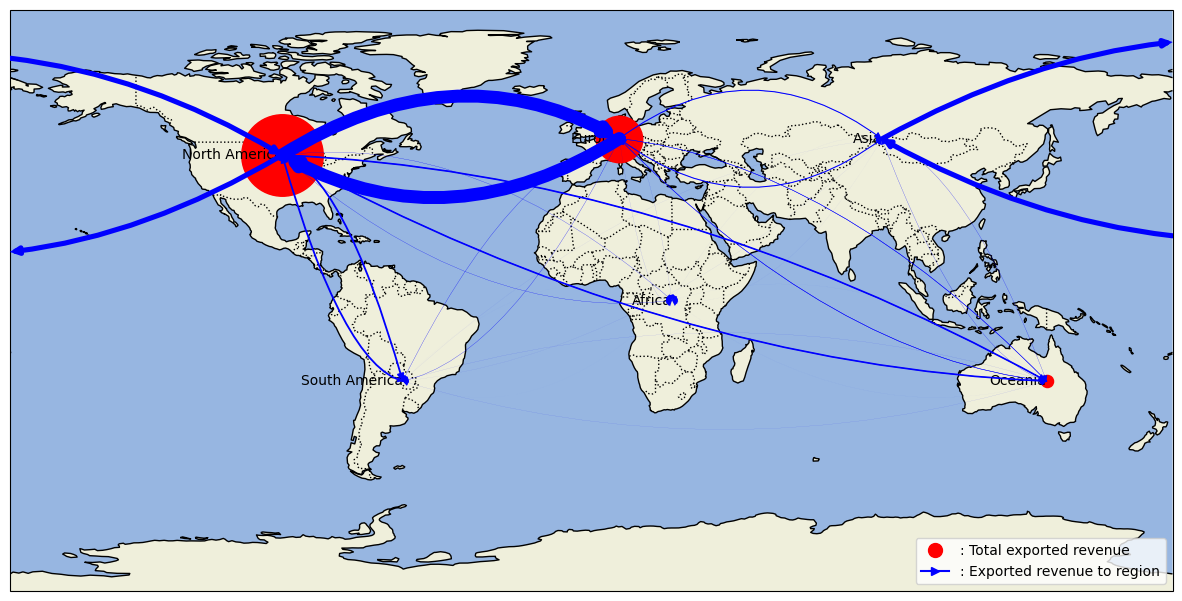

In [27]:
# Step 6: Visualize the Graph
fig, ax = plt.subplots(
    figsize=(15, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the extent of the map to include all the points
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Normalize edge weights
edge_weights = np.array([data['weight'] for _, _, data in G.edges(data=True)])
edge_weights_norm = 5 * edge_weights / edge_weights.max()

# Normalize node sizes
node_sizes = {node: G.out_degree(node, weight='weight') for node in G.nodes()}
max_size = max(node_sizes.values())
node_sizes_transformed = {node: 50 * size / max_size for node, size in node_sizes.items()}

# Draw nodes with adjusted sizes
for node, (lon, lat) in pos.items():
    size = node_sizes_transformed.get(node, 0)  
    ax.plot(lon, lat, marker='o', color='red', markersize=15*np.log(size), transform=ccrs.Geodetic())
    ax.text(lon, lat, node, verticalalignment='center', horizontalalignment='right', transform=ccrs.Geodetic())

# Get the maximum weight for normalization
max_weight = max(nx.get_edge_attributes(G, 'weight').values())

# Draw edges with Bezier curves
for (u, v, data) in G.edges(data=True):
    if u != v :  # Skip self-loops for visualization
        start_pos, end_pos = pos[u], pos[v]
        weight = data['weight']
        normalized_weight = 15 * weight / max_weight  

        if ((u=='North America' and v=='Asia') or (u=='Asia' and v=='North America')):
            draw_global_edge(ax, pos['Asia'], pos['North America'], color='blue', lw=normalized_weight)
            draw_global_edge(ax, pos['North America'], pos['Asia'], color='blue', lw=normalized_weight)

        else :
            # Offset the control points for bidirectional edges
            control_point = offset_control_point(start_pos, end_pos, offset=30)
            control_point_reverse = offset_control_point(start_pos, end_pos, offset=-30)

            # Draw edge from u to v
            draw_bezier_arrow(ax, start_pos, end_pos, control_point, color='blue', lw=normalized_weight, zorder=10)
            # Draw edge from v to u
            draw_bezier_arrow(ax, end_pos, start_pos, control_point_reverse, color='blue', lw=normalized_weight, zorder=10)

# Create a custom legend entry for nodes
node_legend = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label=': Total exported revenue')

# Create a custom legend entry for edges
edge_legend = mlines.Line2D([], [], color='blue', marker='>', linestyle='-', label=': Exported revenue to region')

# Add the legend to the plot
ax.legend(handles=[node_legend, edge_legend], loc='lower right')  


plt.show()

In [10]:
def prepare_data(df, explode_column):
    df = df.copy()

    # Explode the 'genres' column to have one genre per row
    df['genres'] = df['genres'].apply(lambda x: x if isinstance(x, list) else [])
    genre_exploded_df = df.explode('genres')

    # Group by region and genre, then sum the gross
    region_genre_gross_df = genre_exploded_df.groupby([explode_column, 'genres'])['divided_gross'].sum().reset_index()

    return region_genre_gross_df

def identify_top_genres(df, n=15):
    return df.groupby('genres')['divided_gross'].sum().nlargest(n).index

def modify_dataframe(df, column, top_genres):
    modified_df = pd.DataFrame()
    
    for group in df[column].unique():
        # Filter dataframe for the current group
        df_group = df[df[column] == group]

        # Select rows with top genres and sum the rest as 'Other'
        top_genres_df = df_group[df_group['genres'].isin(top_genres)]
        other_gross = df_group[~df_group['genres'].isin(top_genres)]['divided_gross'].sum()
        other_row = pd.DataFrame({column: [group], 'genres': ['Other'], 'divided_gross': [other_gross]})

        # Combine top genres and 'Other' row
        modified_df = pd.concat([modified_df, top_genres_df, other_row], ignore_index=True)

    return modified_df

def plot_pie_charts(df, column, title, filename):
    # Create the 2x3 grid layout
    fig = make_subplots(rows=2, cols=3, specs=[[{'type':'pie'}, {'type':'pie'}, {'type':'pie'}],
                                               [{'type':'pie'}, {'type':'pie'}, {'type':'pie'}]],
                        subplot_titles=df[column].unique())

    # Track which cell we are plotting in
    row, col = 1, 1

    # Plot each region's pie chart
    for region in df[column].unique():
        df_region = df[df[column] == region]
        fig.add_trace(go.Pie(labels=df_region['genres'], values=df_region['divided_gross'] / 1000000, name=region, sort=False,
                             hovertemplate= "Genre: %{label}<br>Revenue: %{value:,d}M<br>%{percent}<extra></extra>", textinfo="none"), row=row, col=col)        
        # Update row and column indices for the next plot
        col += 1
        if col > 3:
            col = 1
            row += 1

    # Update layout for a shared legend and adjust it to your preference
    fig.update_layout(showlegend=True, legend_title_text='Genres')

    # Add a general title and adjust the margins to create more space between the titles and the charts
    fig.update_layout(
        title_text=title,  
        title_x=0.5,  # Center the general title
        margin=dict(t=120, l=20, r=20, b=20)  # Adjust top margin to increase space
    )

    # Adjust the position of each subplot title to add more space
    for i in range(len(df[column].unique())):
        fig.layout.annotations[i].update(y=fig.layout.annotations[i].y + 0.05)

    # Show the figure
    fig.show()

    # # Export to HTML
    # fig.write_html(filename)

# Exported genres

In [59]:
# Filter out domestic gross
column_treated = 'co_production_region'
export_only_df = exploded_df[exploded_df[column_treated] != exploded_df['success_region']]

prepared_df = prepare_data(export_only_df, column_treated)
top_genres = identify_top_genres(prepared_df, 10)
modified_df = modify_dataframe(prepared_df, column_treated, top_genres)

plot_pie_charts(modified_df, column_treated, 'Most exported genres per region', 'docs/plots/pie_chart_exported.html')

# Most watched genre

In [60]:
column_treated = 'success_region'

prepared_df = prepare_data(exploded_df, column_treated)
top_genres = identify_top_genres(prepared_df, 10)
modified_df = modify_dataframe(prepared_df, column_treated, top_genres)

plot_pie_charts(modified_df, column_treated, 'Most watched genres per region', 'docs/plots/pie_chart_watched.html')

# Co-production network

Here, we create the coproduction network as follows : we create an edge between all countries that did a coproduction. The weight of the edge will be the sum of the gross revenue of the films corpoduced in the countries 

In [65]:
df_coprod = df_network[df_network['is_home_country']].copy()
df_coprod = df_coprod[df_coprod['countries'].apply(lambda x: len(x) > 1)]
df_coprod = df_coprod[['movie', 'countries','total_gross']]
df_coprod = df_coprod.drop_duplicates(subset='movie')

df_coprod.head()

,movie,countries,total_gross
159,rudo y cursi,"[Mexico, Domestic]",11169232.0
543,closing the ring,"[Domestic, Canada, United Kingdom]",1438942.0
688,hermanas,"[Spain, Argentina, Brazil]",179121.0
1114,becoming jane,"[Ireland, United Kingdom]",37064067.0
2304,heidi fleiss: hollywood madam,"[Domestic, Canada, United Kingdom, Germany]",34402.0


In [66]:
from itertools import combinations
import networkx as nx

# Initialize an empty graph
G = nx.Graph()

# Iterate over each row in the DataFrame
for index, row in df_coprod.iterrows():
    # Get all combinations of two countries for each movie
    for pair in combinations(row['countries'], 2):
        # Check if the edge already exists
        if G.has_edge(pair[0], pair[1]):
            # Update the weight (total_gross) by adding the new value
            G[pair[0]][pair[1]]['weight'] += row['total_gross']
        else:
            # Add a new edge with the total_gross as the initial weight
            G.add_edge(pair[0], pair[1], weight=row['total_gross'])

#print all nodes
list(G.nodes())


['Mexico',
 'Domestic',
 'Canada',
 'United Kingdom',
 'Spain',
 'Argentina',
 'Brazil',
 'Ireland',
 'Germany',
 'Hong Kong',
 'China',
 'France',
 'Italy',
 'Japan',
 'Australia',
 'New Zealand',
 'Switzerland',
 'India',
 'Poland',
 'Denmark',
 'Sweden',
 'Austria',
 'Hungary',
 'Chile',
 'South Korea',
 'South Africa',
 'Middle East',
 'Netherlands',
 'Norway',
 'Colombia',
 'Serbia and Montenegro',
 'Greece',
 'Slovakia',
 'Czech Republic',
 'Finland',
 'Jamaica',
 'Bolivia',
 'Romania',
 'Central America',
 'Morocco',
 'Israel',
 'Belgium',
 'Kenya',
 'Uruguay',
 'Palestine',
 'Kuwait',
 'United Arab Emirates',
 'Portugal',
 'Tunisia',
 'Peru',
 'Russia',
 'E/W Africa',
 'North Macedonia',
 'Yugoslavia',
 'Nigeria',
 'Singapore',
 'Malaysia',
 'Indonesia',
 'Malta',
 'Pakistan',
 'Panama',
 'Egypt',
 'Iceland',
 'Iraq',
 'S/E/W Africa',
 'Philippines',
 'Croatia',
 'Bosnia',
 'Russia/CIS',
 'Lebanon',
 'Mongolia',
 'Lithuania',
 'Puerto Rico',
 'Bangladesh',
 'Slovenia',
 'Venezu

Now we will create the map 

In [67]:
#we load the cooordinates for each country 
country_coords = pd.read_csv('dictionnaries/country_coordinates.csv')

# Create a dictionary of country coordinates
pos = dict(zip(country_coords['Country'], zip(country_coords['Longitude'],country_coords['Latitude'])))


Now we will try to make the graph interactive 

In [68]:
# Create a Plotly figure
fig = go.Figure()

# Compute node weights based on the sum of weights of edges connected to the node
node_weights = {node: 0 for node in G.nodes()}
for (u, v, data) in G.edges(data=True):
    weight = data['weight']
    node_weights[u] += weight
    node_weights[v] += weight

# Normalize the weights
max_weight = max(node_weights.values())
for node in node_weights:
    node_weights[node] = 15 * node_weights[node] / max_weight

visible_marker_size_factor = 15
invisible_marker_size = 15  # Minimum size to ensure visibility

for country in G.nodes():
    lon, lat = pos[country]
    if country in node_weights:
        node_weight = node_weights[country]
        revenue_in_millions = node_weight * max_weight / 15 / 1e6
        formatted_weight = "{:,.0f}M".format(revenue_in_millions)
        node_text = f"<b>{country}</b><br>Coproduced revenue : <b>${formatted_weight}</b>"

        
        # Ensure positive and non-zero weight for logarithmic scale
        adjusted_weight = max(node_weight, 1)
        visible_marker_size = np.log(adjusted_weight) * visible_marker_size_factor

        # Add visible marker
        fig.add_trace(go.Scattergeo(
            lon=[lon],
            lat=[lat],
            hoverinfo='text',
            text=node_text,
            mode='markers',
            marker=dict(size=visible_marker_size, color='red'),
        ))

        # Add invisible marker for improved hover interaction
        fig.add_trace(go.Scattergeo(
            lon=[lon],
            lat=[lat],
            hoverinfo='text',
            text=node_text,
            mode='markers',
            marker=dict(size=invisible_marker_size,color='red', opacity=0),  # Invisible but large enough for hovering
        ))

# Add edges
for (u, v, data) in G.edges(data=True):
    if u in pos and v in pos:
        start = pos[u]
        end = pos[v]
        weight = data['weight'] / max_weight * 15
        edge_text = f"Co-production between {u} and {v}, Revenue: {data['weight']:,.0f}"

        fig.add_trace(go.Scattergeo(
            lon=[start[0], end[0], None],  # None creates a segment (break) between edges
            lat=[start[1], end[1], None],
            mode='lines',
            line=dict(width=weight, color='blue'),
            hoverinfo='none',
            text=edge_text  # Text to display on hover
        ))

fig.update_layout(
    title='Interactive Map of Country Co-productions',
    showlegend=False,
    geo=dict(
        projection_type='natural earth',
        showland=True,
        landcolor='lightgreen',
        countrycolor='gray',
    )
)

fig.show()

# Export to HTML
# html_file_path = 'docs/plots/country_co-productions.html'
# fig.write_html(html_file_path)

